In [1]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import ast
from typing import List, Tuple

from collections import defaultdict
from typing import List                                                                                                         
from tqdm import tqdm

# 30 sec

In [2]:
from Enum.EnergyRange import EnergyRange
from Enum.Flavour import Flavour

In [3]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [4]:
csvs_high = {
    # r"35, E$\in$(1PeV,100PeV), train(0m), val_loss(0.1612), val(0m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_103618/102954/predictions_epoch_010_val_loss_0.1612.csv",
    r"35, E$\in$(1PeV,100PeV), train(0m), val_loss(0.1612), val(250m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_103618/103202/predictions_epoch_010_val_loss_0.1612.csv",
    # r"35, E$\in$(1PeV,100PeV), train(0m), val_loss(0.1612), val(contain)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_103618/103333/predictions_epoch_010_val_loss_0.1612.csv",
    # r"35, E$\in$(1PeV,100PeV), train(250m), val_loss(0.1604), val(0m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_225437/103550/predictions_epoch_025_val_loss_0.1604.csv",
    r"35, E$\in$(1PeV,100PeV), train(250m), val_loss(0.1604), val(250m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_225437/103939/predictions_epoch_025_val_loss_0.1604.csv",
    # r"35, E$\in$(1PeV,100PeV), train(250m), val_loss(0.1604), val(contain)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_225437/104343/predictions_epoch_025_val_loss_0.1604.csv",
    # r"35, E$\in$(1PeV,100PeV), train(contain), val_loss(0.1604), val(0m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_194327/104604/predictions_epoch_014_val_loss_0.1654.csv",
    r"35, E$\in$(1PeV,100PeV), train(contain), val_loss(0.1604), val(250m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_194327/104639/predictions_epoch_014_val_loss_0.1654.csv",
    # r"35, E$\in$(1PeV,100PeV), train(contain), val_loss(0.1604), val(contain)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_194327/104704/predictions_epoch_014_val_loss_0.1654.csv",
    }
csvs_medium = {
    r"35, E$\in$(10TeV,1PeV), train(0m), val_loss(0.1595), val(0m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_141042/111631/predictions_epoch_004_val_loss_0.1595.csv",
    r"35, E$\in$(10TeV,1PeV), train(0m), val_loss(0.1595), val(250m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_141042/111731/predictions_epoch_004_val_loss_0.1595.csv",
    r"35, E$\in$(10TeV,1PeV), train(0m), val_loss(0.1595), val(contain)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_141042/111839/predictions_epoch_004_val_loss_0.1595.csv",
    r"35, E$\in$(10TeV,1PeV), train(250m), val_loss(0.1567), val(0m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_224941/112533/predictions_epoch_004_val_loss_0.1567.csv",
    r"35, E$\in$(10TeV,1PeV), train(250m), val_loss(0.1567), val(250m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_224941/112608/predictions_epoch_004_val_loss_0.1567.csv",
    r"35, E$\in$(10TeV,1PeV), train(250m), val_loss(0.1567), val(contain)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_224941/112657/predictions_epoch_004_val_loss_0.1567.csv",
    r"35, E$\in$(10TeV,1PeV), train(contain), val_loss(0.1563), val(0m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_194527/113259/predictions_epoch_044_val_loss_0.1563.csv",
    r"35, E$\in$(10TeV,1PeV), train(contain), val_loss(0.1563), val(250m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_194527/113352/predictions_epoch_044_val_loss_0.1563.csv",
    r"35, E$\in$(10TeV,1PeV), train(contain), val_loss(0.1563), val(contain)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250327/model_20250326_194527/113436/predictions_epoch_044_val_loss_0.1563.csv",
    }


In [5]:
def enhance_probs(probs: np.ndarray) -> np.ndarray:
    epsilon = 1e-7
    p_e = probs * (1- 2*epsilon) + epsilon
    return np.log(p_e / (1-p_e))

In [6]:
def get_probs(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    df["probs"] = df["probs"].apply(ast.literal_eval)  # Convert string to list

    p_nu_e = np.array([p[0] for p in df[df["target_class"] == 0]['probs']])
    p_nu_mu = np.array([p[1] for p in df[df["target_class"] == 1]['probs']])
    p_nu_tau = np.array([p[2] for p in df[df["target_class"] == 2]['probs']])
    p_nu_e = enhance_probs(p_nu_e)
    p_nu_mu = enhance_probs(p_nu_mu)
    p_nu_tau = enhance_probs(p_nu_tau)
    return p_nu_e, p_nu_mu, p_nu_tau


In [7]:
def get_logits(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    df["logits"] = df["logits"].apply(ast.literal_eval)  # Convert string to list

    l_nu_e = np.array([l[0] for l in df[df["target_class"] == 0]['logits']])
    l_nu_mu = np.array([l[1] for l in df[df["target_class"] == 1]['logits']])
    l_nu_tau = np.array([l[2] for l in df[df["target_class"] == 2]['logits']])

    return l_nu_e, l_nu_mu, l_nu_tau

In [8]:
E = ("nu_e", r"\nu_e", 12)

In [9]:
def plot_prob_distribution(p_nu_e: List[float],
                           p_nu_mu: List[float], 
                           p_nu_tau: List[float], 
                           label: str):
    fig, ax = plt.subplots(figsize=(11, 7))
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(p_nu_e, binwidth=0.05)
    ax.hist(p_nu_e, bins=bins, histtype='step', label=fr"${Flavour.E.latex}$", color=getColour(2))
    ax.hist(p_nu_mu, bins=bins, histtype='step', label=fr"${Flavour.MU.latex}$", color=getColour(0))
    ax.hist(p_nu_tau, bins=bins, histtype='step', label=fr"${Flavour.TAU.latex}$", color=getColour(1))
    ax.set_xlabel("Probability")
    ax.set_ylabel("Counts")
    ax.set_title(f"softmax(logit) distribution of {label}")
    ax.legend()
    plt.show()
    

In [10]:
def plot_logit_distribution(l_nu_e: List[float], 
                            l_nu_mu: List[float], 
                            l_nu_tau: List[float], 
                            label: str,
                            manifier: Tuple[float, float] = None):
    fig, ax = plt.subplots(figsize=(13, 8))
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(l_nu_e, binwidth=0.005)
    ax.hist(l_nu_tau, bins=bins, histtype='step', label=fr"${Flavour.TAU.latex}$", color=getColour(1))
    ax.hist(l_nu_mu, bins=bins, histtype='step', label=fr"${Flavour.MU.latex}$", color=getColour(0))
    ax.hist(l_nu_e, bins=bins, histtype='step', label=fr"${Flavour.E.latex}$", color=getColour(2))
    ax.set_xlabel("Logit")
    ax.set_ylabel("Counts")
    ax.set_title(f"Logit of {label}")
    if manifier:
        ax.set_xlim(manifier)
    else:
        ax.set_xlim(-0.1, 1.0)
    
    d_e = {
        r'$\nu_e$': "",
        "N": len(l_nu_e),
        "max": np.max(l_nu_e),
        "min": np.min(l_nu_e),
        "mean": np.mean(l_nu_e),
        "median": np.median(l_nu_e),
        }
    d_mu = {
        r'$\nu_\mu$': "",
        "N": len(l_nu_mu),
        "max": np.max(l_nu_mu),
        "min": np.min(l_nu_mu),
        "mean": np.mean(l_nu_mu),
        "median": np.median(l_nu_mu),
        }
    d_tau = {
        r'$\nu_\tau$': "",
        "N": len(l_nu_tau),
        "max": np.max(l_nu_tau),
        "min": np.min(l_nu_tau),
        "mean": np.mean(l_nu_tau),
        "median": np.median(l_nu_tau),
        }
    add_text_to_ax(0.1, 0.95, nice_string_output(d_e), ax, fontsize=10)
    add_text_to_ax(0.1, 0.75, nice_string_output(d_mu), ax, fontsize=10)
    add_text_to_ax(0.1, 0.55, nice_string_output(d_tau), ax, fontsize=10)
        
    ax.legend()
    plt.show()

In [11]:
def run_plot(csv, id):
    df = pd.read_csv(csv)
    # p_nu_e, p_nu_mu, p_nu_tau = get_probs(df)
    # plot_prob_distribution(p_nu_e, p_nu_mu, p_nu_tau, id)
    l_nu_e, l_nu_mu, l_nu_tau = get_logits(df)
    plot_logit_distribution(l_nu_e, l_nu_mu, l_nu_tau, id)
    plot_logit_distribution(l_nu_e, l_nu_mu, l_nu_tau, id, manifier=(0.8, 1.0))

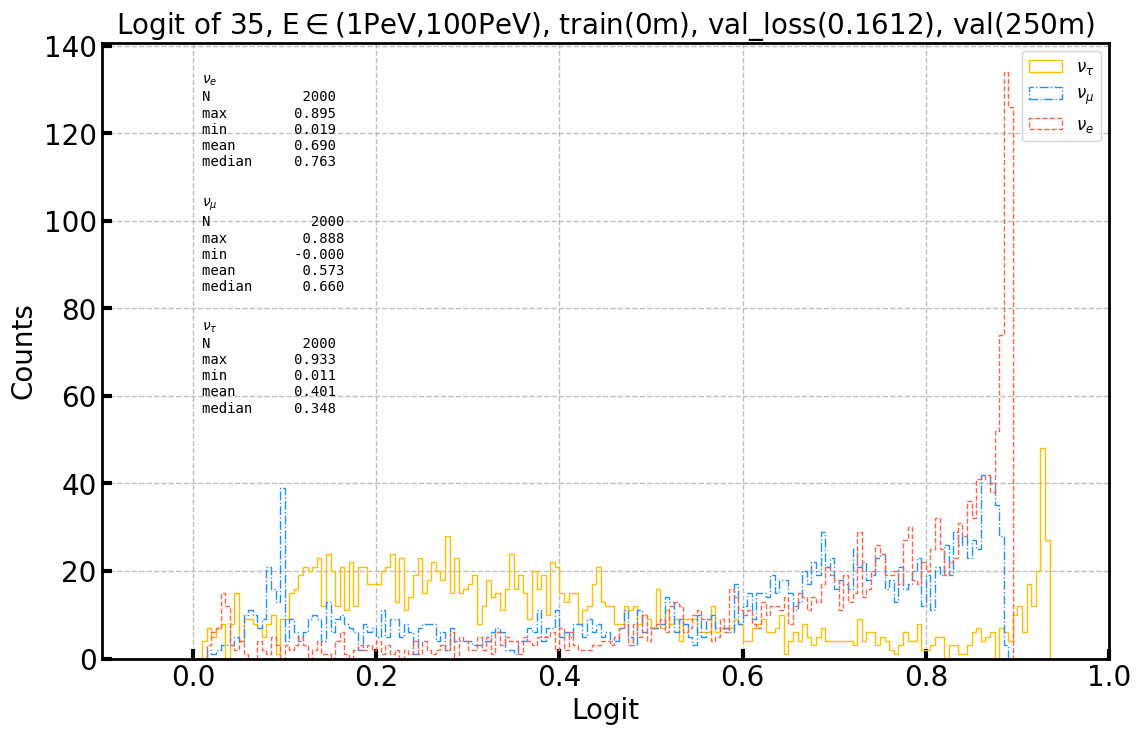

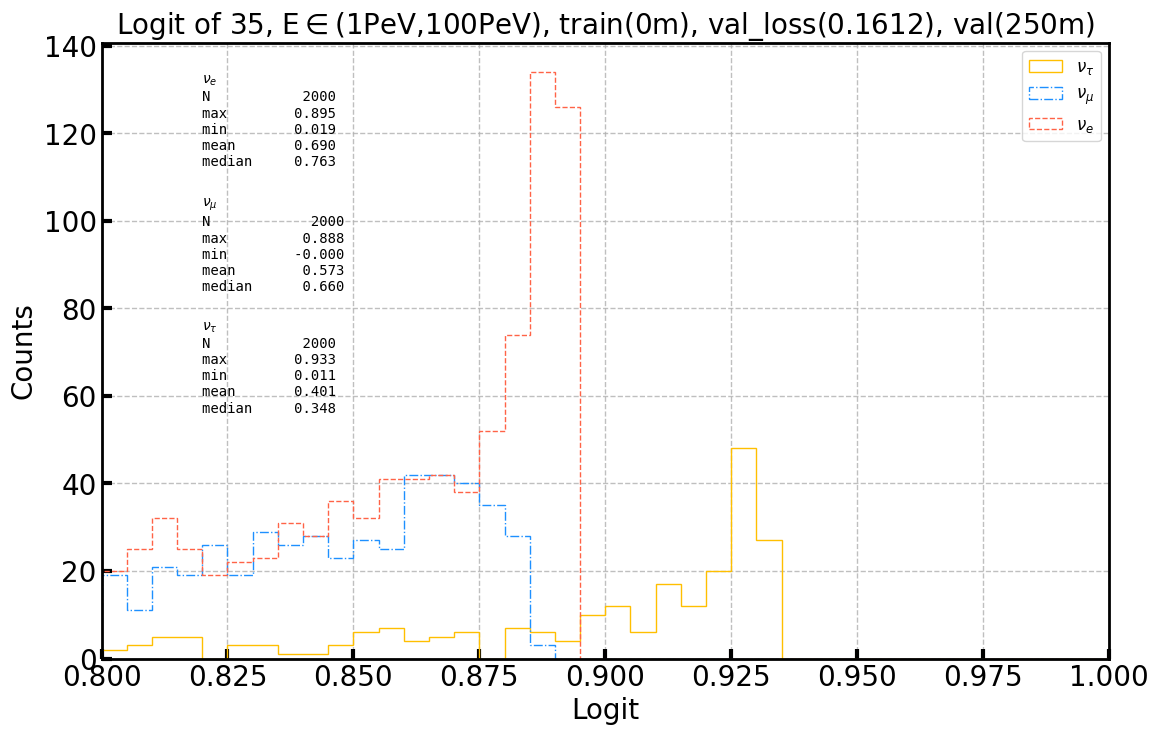

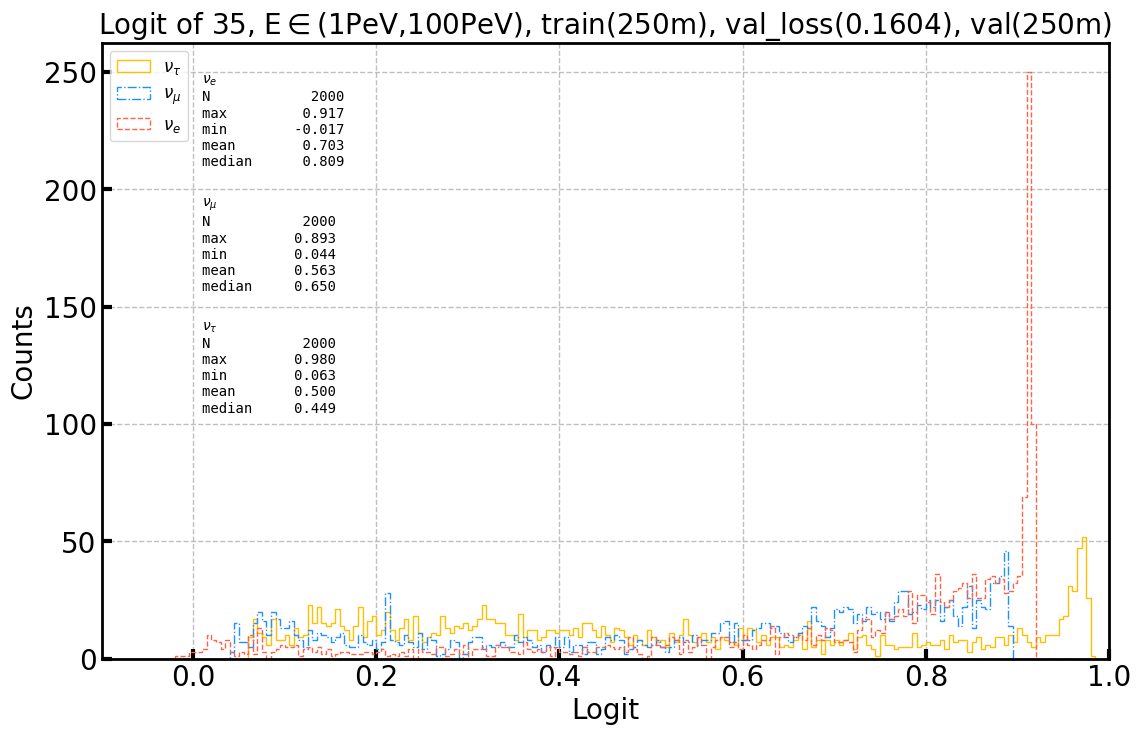

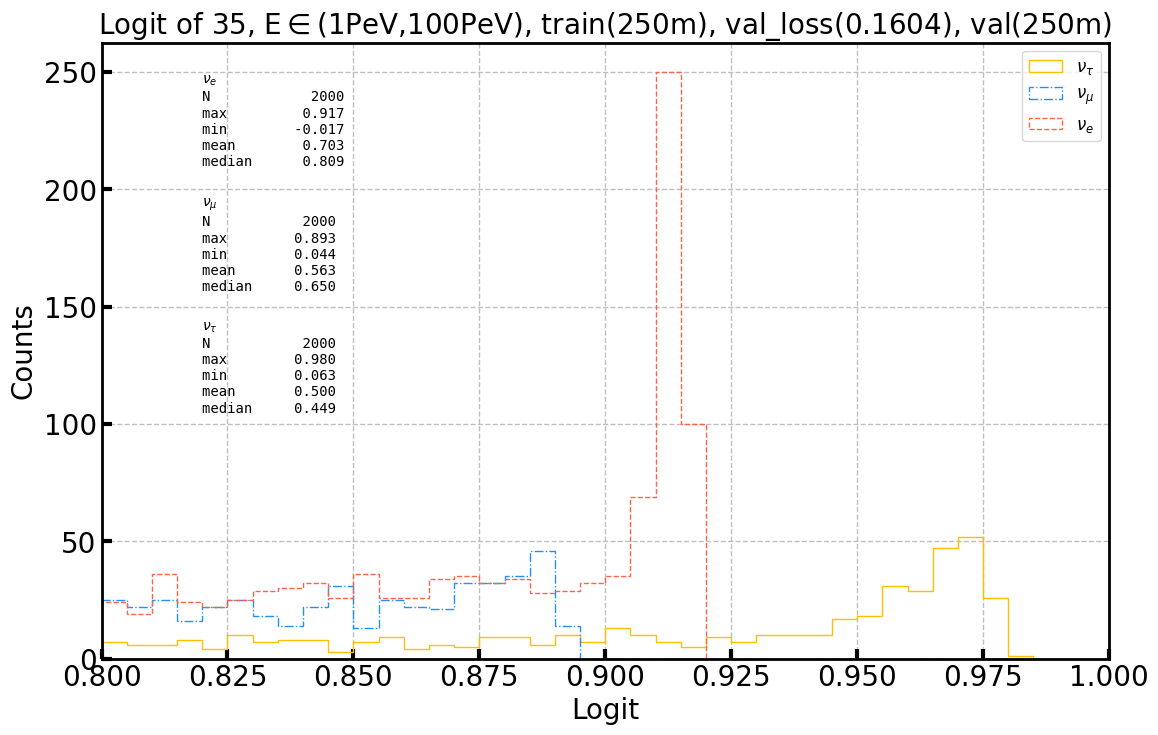

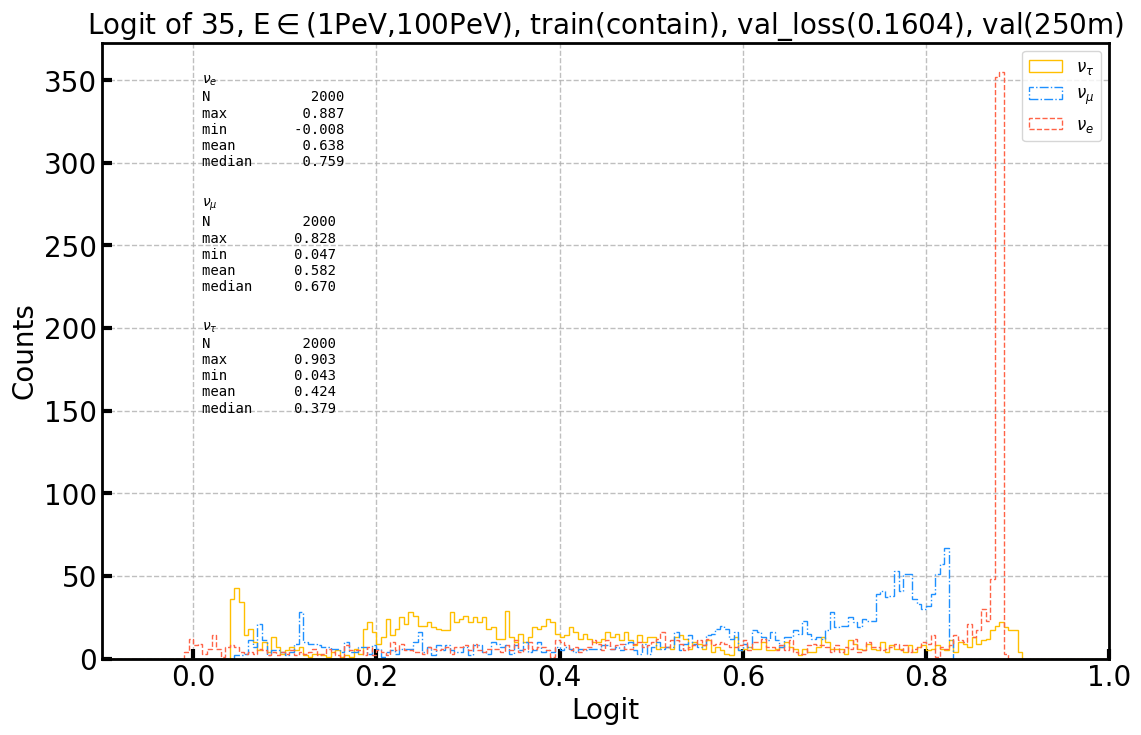

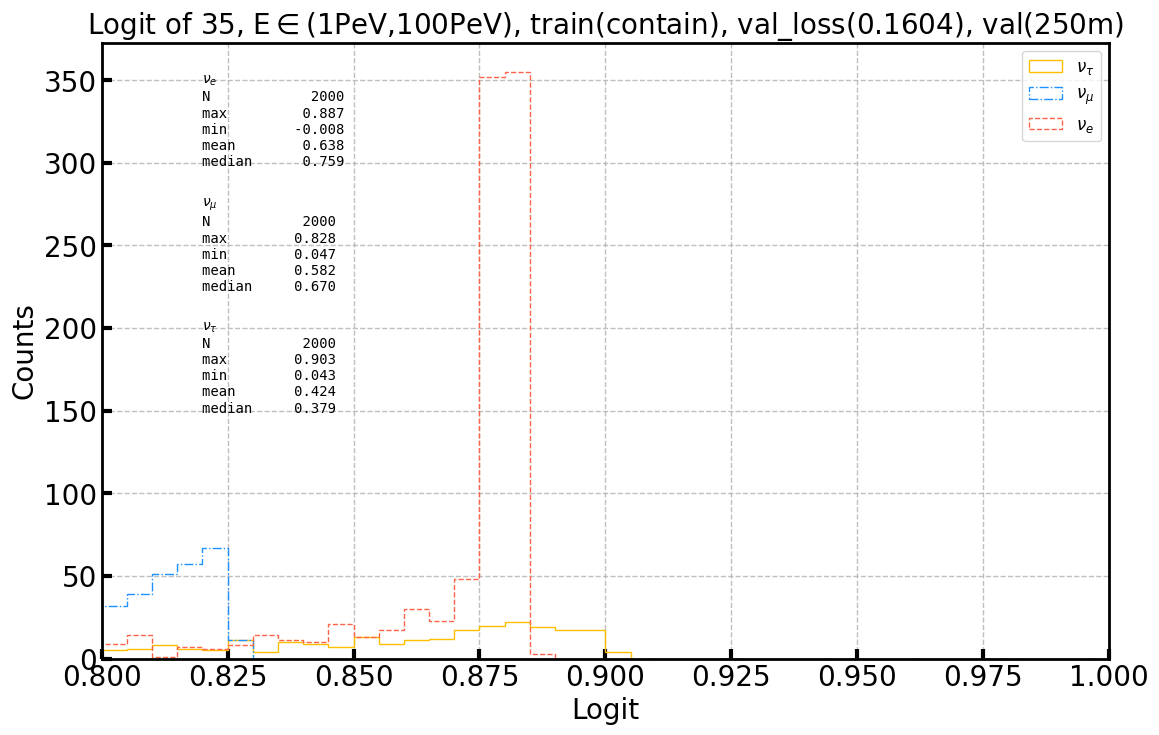

In [12]:
for id, csv in csvs_high.items():
    run_plot(csv, id)

In [13]:
# for id, csv in csvs_medium.items():
#     run_plot(csv, id)